In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# 1. Load and Clean Data
# ---------------------------
df = pd.read_csv("Uber-Jan-Feb-FOIL.csv")

In [ ]:
# Convert date column
df['date'] = pd.to_datetime(df['date'])


In [ ]:
# Aggregate by base number (to get rider/driver usage pattern)
rider_usage = df.groupby('dispatching_base_number').agg({
    'active_vehicles': 'mean',
    'trips': ['mean', 'sum']
}).reset_index()

In [ ]:
# Flatten columns
rider_usage.columns = ['base', 'avg_active_vehicles', 'avg_trips', 'total_trips']

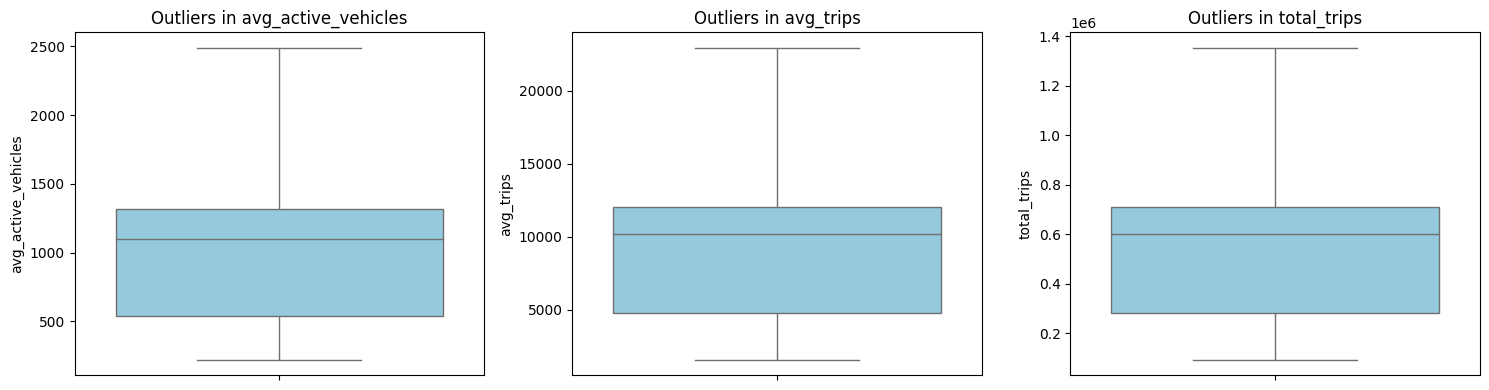

In [ ]:
#Outlier Visualization (Before Clipping)
# ---------------------------
plt.figure(figsize=(15,4))
for i, col in enumerate(['avg_active_vehicles','avg_trips','total_trips']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=rider_usage[col], color='skyblue')
    plt.title(f"Outliers in {col}")
plt.tight_layout()
plt.show()



In [ ]:
# Handle outliers (IQR clipping)
for col in ['avg_active_vehicles', 'avg_trips', 'total_trips']:
    Q1 = rider_usage[col].quantile(0.25)
    Q3 = rider_usage[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    rider_usage[col] = np.clip(rider_usage[col], lower, upper)

In [ ]:
# 2. Feature Scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rider_usage[['avg_active_vehicles', 'avg_trips', 'total_trips']])

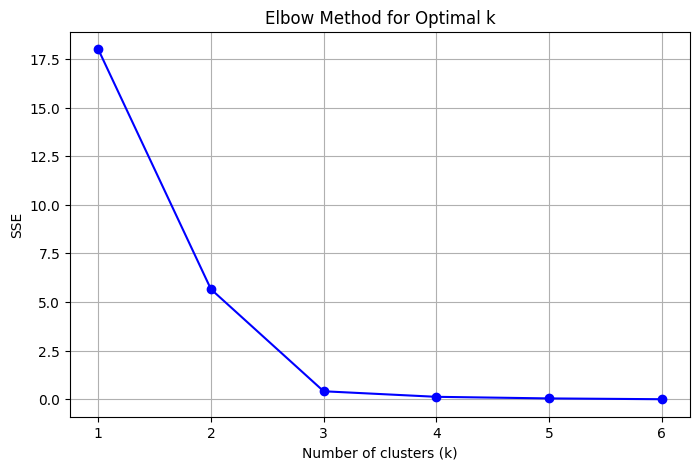

In [ ]:
# 3. Find Optimal k (Elbow)

sse = []
K = range(1, len(X_scaled) + 1) # Iterate up to the number of samples
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to suppress warning
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Pick k=3 (based on elbow)
k = 3

In [ ]:
# 4. K-Means Clustering

kmeans = KMeans(n_clusters=k, random_state=42)
rider_usage['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# 5. Hierarchical Clustering

hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
rider_usage['Hierarchical_Cluster'] = hier.fit_predict(X_scaled)

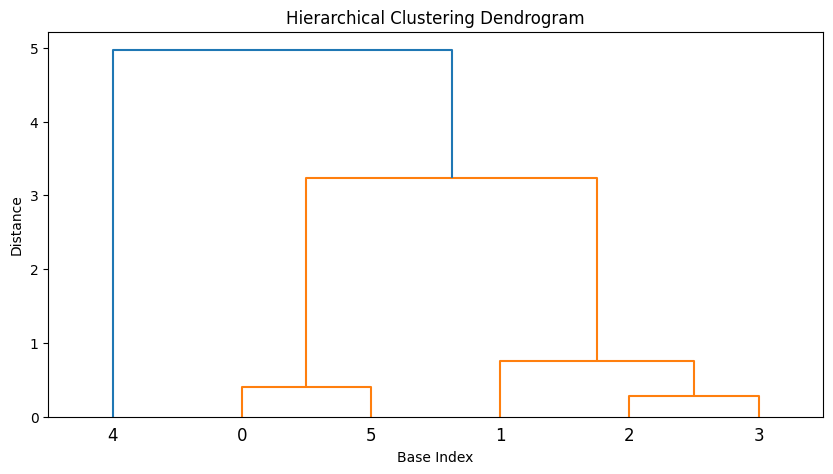

In [ ]:
# 6. Dendrogram (Optional)

linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Base Index')
plt.ylabel('Distance')
plt.show()

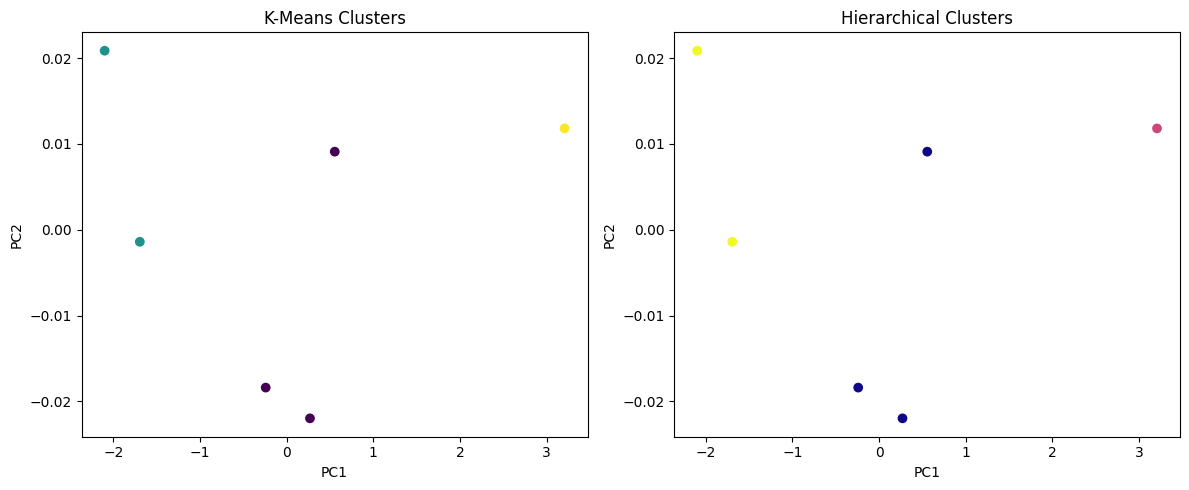

In [ ]:
# PCA for 2D Visualization
# ---------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=rider_usage['KMeans_Cluster'], cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=rider_usage['Hierarchical_Cluster'], cmap='plasma')
plt.title('Hierarchical Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()


In [ ]:
# 8. Display Results
# ---------------------------
print("\nClustered Results:")
print(rider_usage)


Clustered Results:
     base  avg_active_vehicles     avg_trips  total_trips  KMeans_Cluster  \
0  B02512           222.457627   1589.593220    93786.000               1   
1  B02598           994.118644   9165.949153   540791.000               0   
2  B02617          1351.830508  12288.559322   725025.000               0   
3  B02682          1210.694915  11228.966102   662509.000               0   
4  B02764          2488.116525  22929.061441  1352814.625               2   
5  B02765           382.627119   3282.542373   193670.000               1   

   Hierarchical_Cluster  
0                     2  
1                     0  
2                     0  
3                     0  
4                     1  
5                     2  


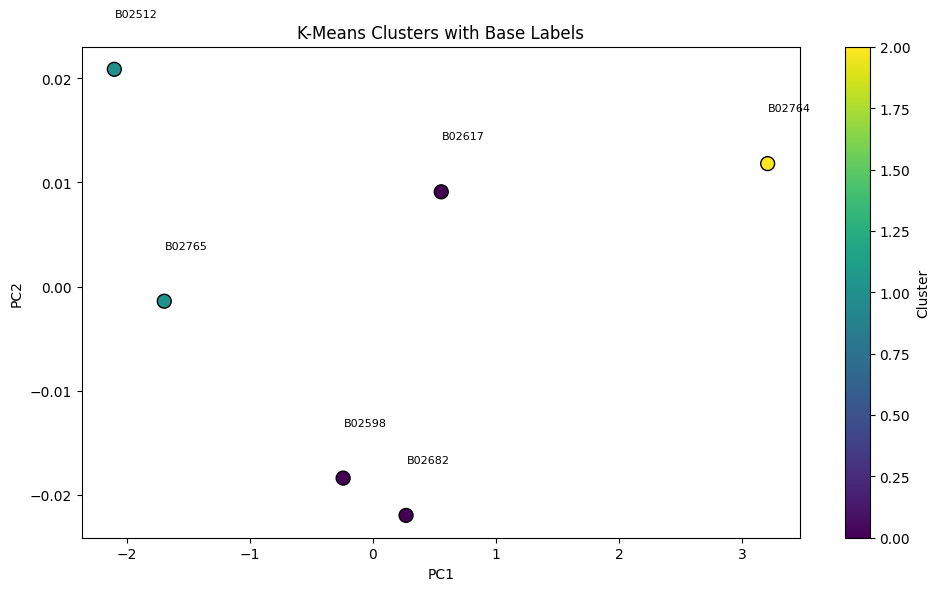

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                      c=rider_usage['KMeans_Cluster'], cmap='viridis', s=100, edgecolors='k')
plt.title('K-Means Clusters with Base Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Annotate each point with its base number
for i, base in enumerate(rider_usage['base']):
    plt.text(X_pca[i,0]+0.005, X_pca[i,1]+0.005, base, fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()
